In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
import warnings
from tqdm import tqdm

# Improving best model parameters

Now we can try to find the best parameters to add for every model to fit perfectly the data. In this part of the study we will remove some of the least performing algorithm and focus on the more promizing ones. Ie the GBM (as always), the CEV and Merton Jump

In [ ]:
# Define parameters
ticker = "EURUSD=X"
end_date = dt.date.today()
start_date = end_date - dt.timedelta(days=60)  # Max allowed for 5-min data
interval = "5m"

# Fetch data in chunks (10-day increments to avoid API limits)
all_data = []
chunk_size = 10
current_start = start_date

while current_start < end_date:
    current_end = min(current_start + dt.timedelta(days=chunk_size), end_date)
    data = yf.download(ticker, start=current_start, end=current_end, interval=interval)

    if not data.empty:
        all_data.append(data)

    current_start = current_end

# Combine chunks into a single DataFrame
fx_data_5m = pd.concat(all_data).dropna()

# Print summary
print(f"Fetched {len(fx_data_5m)} data points")
print(fx_data_5m.head())

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['EURUSD=X']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-01-11 -> 2025-01-21) (Yahoo error = "5m data not available for startTime=1736553600 and endTime=1737417600. The requested range must be within the last 60 days.")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetched 10236 data points
Price                         Close      High       Low      Open   Volume
Ticker                     EURUSD=X  EURUSD=X  EURUSD=X  EURUSD=X EURUSD=X
Datetime                                                                  
2025-01-21 00:00:00+00:00  1.042970  1.042970  1.042427  1.042427        0
2025-01-21 00:05:00+00:00  1.043079  1.043297  1.042970  1.043079        0
2025-01-21 00:10:00+00:00  1.043188  1.043623  1.043079  1.043406        0
2025-01-21 00:15:00+00:00  1.043297  1.043297  1.042753  1.042753        0
2025-01-21 00:20:00+00:00  1.043188  1.043406  1.043188  1.043297        0


In [ ]:
# Suppress specific warnings related to optimization
warnings.filterwarnings('ignore', category=RuntimeWarning, module='scipy.optimize')
warnings.filterwarnings('ignore', category=RuntimeWarning, module='numpy.core')

In [ ]:
# ============================
# DATA PREPARATION FUNCTIONS
# ============================

def preprocess_fx_data(data, freq='5min'):
    """
    Preprocess FX data for model calibration.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing FX data with at least a 'Close' column
    freq : str
        Frequency to resample the data if needed

    Returns:
    --------
    pd.DataFrame
        Processed data with returns and log returns columns
    """
    # Ensure data is sorted by time
    if isinstance(data.index, pd.DatetimeIndex):
        data = data.sort_index()

    # Calculate returns and log returns
    prices = data['Close'].copy()

    # Calculate simple and log returns
    returns = prices.pct_change().dropna()
    log_returns = np.log(prices / prices.shift(1)).dropna()

    # Remove outliers (more than 5 standard deviations)
    returns_mean = returns.mean()
    returns_std = returns.std()
    log_returns_mean = log_returns.mean()
    log_returns_std = log_returns.std()

    valid_returns = (returns > returns_mean - 5 * returns_std) & (returns < returns_mean + 5 * returns_std)
    valid_log_returns = (log_returns > log_returns_mean - 5 * log_returns_std) & (log_returns < log_returns_mean + 5 * log_returns_std)

    # Create a DataFrame with both types of returns, handling empty columns
    processed_data = pd.DataFrame(index=prices.index) # Create DataFrame with original index
    processed_data['Close'] = prices

    # Use .any().any() to get a single boolean value
    if valid_returns.any().any():
        processed_data['returns'] = returns.where(valid_returns)
    else:
        processed_data['returns'] = np.nan  # Assign NaN if all returns are outliers

    if valid_log_returns.any().any():
        processed_data['log_returns'] = log_returns.where(valid_log_returns)
    else:
        processed_data['log_returns'] = np.nan  # Assign NaN if all log returns are outliers

    processed_data = processed_data.dropna()

    # Print data statistics
    print(f"Data statistics after preprocessing:")
    print(f"Number of observations: {len(processed_data)}")
    print(f"Returns - Mean: {processed_data['returns'].mean():.8f}, Std: {processed_data['returns'].std():.8f}")
    print(f"Log Returns - Mean: {processed_data['log_returns'].mean():.8f}, Std: {processed_data['log_returns'].std():.8f}")
    print(f"Returns range: [{processed_data['returns'].min():.8f}, {processed_data['returns'].max():.8f}]")

    # Check for normality
    k2, p = stats.normaltest(processed_data['log_returns'].dropna())
    print(f"Log returns normality test: p-value = {p:.8f}")

    return processed_data

processed_data = preprocess_fx_data(fx_data_5m)

Data statistics after preprocessing:
Number of observations: 10204
Returns - Mean: 0.00000666, Std: 0.00029696
Log Returns - Mean: 0.00000662, Std: 0.00029696
Returns range: [-0.00166499, 0.00174693]
Log returns normality test: p-value = 0.00000000


In [ ]:
# ============================
# LIKELIHOOD FUNCTIONS
# ============================

def gbm_log_likelihood(params, returns):
    """
    Log-likelihood function for Geometric Brownian Motion.

    Parameters:
    -----------
    params : array-like
        [mu, sigma] - GBM parameters
    returns : array-like
        Array of log returns

    Returns:
    --------
    float
        Negative log-likelihood (for minimization)
    """
    mu, sigma = params

    # Boundary conditions
    if sigma <= 0:
        return 1e10  # Large penalty for invalid parameters

    # Use a more numerically stable implementation
    n = len(returns)
    sigma_safe = np.clip(sigma, 1e-8, 1e2)  # Prevent extreme values

    log_2pi = 1.83787706641  # Precomputed log(2π)

    # More stable computation by avoiding overflow
    term1 = -n * (log_2pi + 2 * np.log(sigma_safe)) / 2
    term2 = -np.sum(((returns - mu) ** 2)) / (2 * sigma_safe**2)

    log_likelihood = term1 + term2

    # Check for invalid values
    if not np.isfinite(log_likelihood):
        return 1e10

    return -log_likelihood

def cev_log_likelihood(params, returns, S0):
    """
    Log-likelihood function for Constant Elasticity of Variance model.

    Parameters:
    -----------
    params : array-like
        [alpha, beta, mu] - CEV parameters
    returns : array-like
        Array of log returns
    S0 : float
        Initial price level

    Returns:
    --------
    float
        Negative log-likelihood (for minimization)
    """
    alpha, beta, mu = params

    # Ensure S0 is a scalar
    if isinstance(S0, (pd.Series, np.ndarray)):
        S0 = float(S0)

    # Boundary conditions
    if alpha <= 0 or beta < 0 or beta > 2:
        return 1e10  # Large penalty

    # Calculate local volatility
    sigma_t = alpha * (S0 ** beta)
    sigma_t_safe = np.clip(sigma_t, 1e-8, 1e2)  # Prevent extreme values

    # Compute log-likelihood
    n = len(returns)
    log_2pi = 1.83787706641  # Precomputed log(2π)

    term1 = -n * (log_2pi + 2 * np.log(sigma_t_safe)) / 2
    term2 = -np.sum(((returns - mu) ** 2)) / (2 * sigma_t_safe**2)

    log_likelihood = term1 + term2

    # Check for invalid values
    if not np.isfinite(log_likelihood):
        return 1e10

    return -log_likelihood

def merton_log_likelihood(params, returns):
    """
    Log-likelihood function for Merton Jump Diffusion model.

    Parameters:
    -----------
    params : array-like
        [mu, sigma, lambda_, jump_mean, jump_std] - Merton parameters
    returns : array-like
        Array of log returns

    Returns:
    --------
    float
        Negative log-likelihood (for minimization)
    """
    mu, sigma, lambda_, jump_mean, jump_std = params

    # Boundary conditions
    if sigma <= 0 or jump_std <= 0 or lambda_ < 0 or lambda_ > 1:
        return 1e10  # Large penalty

    # Apply safe bounds to prevent numerical issues
    sigma_safe = np.clip(sigma, 1e-8, 1e2)
    jump_std_safe = np.clip(jump_std, 1e-8, 1e2)
    lambda_safe = np.clip(lambda_, 0.001, 0.999)  # Avoid exact 0 or 1

    # Compute the density using a numerically stable method
    diff_normal = returns - mu
    diff_jump = returns - (mu + jump_mean)

    log_2pi = 1.83787706641  # Precomputed log(2π)

    # Calculate log of each component density
    log_normal = -0.5 * log_2pi - np.log(sigma_safe) - 0.5 * (diff_normal / sigma_safe) ** 2
    log_jump = -0.5 * log_2pi - np.log(jump_std_safe) - 0.5 * (diff_jump / jump_std_safe) ** 2

    # Use log-sum-exp trick for numerical stability
    # log(a*exp(x) + b*exp(y)) = log(a) + x + log(1 + b/a * exp(y-x))
    max_log = np.maximum(log_normal, log_jump)
    min_log = np.minimum(log_normal, log_jump)

    # Calculate log mixture likelihood
    log_mix = max_log + np.log((1-lambda_safe) * np.exp(log_normal - max_log) +
                              lambda_safe * np.exp(log_jump - max_log))

    # Sum log likelihoods
    log_likelihood = np.sum(log_mix)

    # Check for invalid values
    if not np.isfinite(log_likelihood):
        return 1e10

    return -log_likelihood

In [ ]:
# ============================
# CALIBRATION FUNCTIONS
# ============================

def calibrate_model(model, returns, S0=None, use_global_opt=False):
    """
    Calibrate financial model parameters using maximum likelihood estimation.

    Parameters:
    -----------
    model : str
        Model name ('GBM', 'CEV', or 'Merton')
    returns : array-like
        Array of returns or log returns
    S0 : float, optional
        Initial price for CEV model
    use_global_opt : bool, optional
        Whether to use global optimization (basinhopping)

    Returns:
    --------
    dict
        Optimized parameters and optimization result
    """
    # Ensure returns are numpy array
    if isinstance(returns, pd.Series):
        returns = returns.dropna().to_numpy()

    # Check if we have enough data
    if len(returns) < 10:
        return None

    # Define model-specific optimization settings
    if model == 'GBM':
        # Initial guesses based on sample statistics
        mu_init = np.mean(returns)
        sigma_init = np.std(returns)

        # Reasonable bounds for 5-min FX data
        # Mu typically small, sigma limited to reasonable range
        init_params = [mu_init, sigma_init]
        bounds = [(-0.01, 0.01), (1e-6, 0.1)]

        opt_func = gbm_log_likelihood
        args = (returns,)

    elif model == 'CEV':
        # Ensure S0 is a scalar
        if S0 is None:
            S0 = 1.0
        elif isinstance(S0, (pd.Series, np.ndarray)):
            S0 = float(S0.iloc[0] if hasattr(S0, 'iloc') else S0[0])

        # Initial parameters
        mu_init = np.mean(returns)
        sigma_init = np.std(returns)

        # CEV model now includes drift parameter
        init_params = [sigma_init, 0.5, mu_init]
        bounds = [(1e-6, 0.1), (0, 2), (-0.01, 0.01)]  # Alpha, Beta, Mu

        opt_func = cev_log_likelihood
        args = (returns, S0)

    elif model == 'Merton':
        # Initial parameters for jump diffusion
        mu_init = np.mean(returns)
        sigma_init = np.std(returns) * 0.5  # Reduced for diffusion component
        lambda_init = 0.1  # Expected 10% of observations are jumps
        jump_mean_init = 0.0  # Zero mean jumps
        jump_std_init = np.std(returns) * 2  # Larger std for jumps

        init_params = [mu_init, sigma_init, lambda_init, jump_mean_init, jump_std_init]
        bounds = [(-0.01, 0.01), (1e-6, 0.1), (0.001, 0.5),
                 (-0.05, 0.05), (1e-6, 0.2)]

        opt_func = merton_log_likelihood
        args = (returns,)

    else:
        raise ValueError(f"Unknown model: {model}")

    # Define optimization options
    options = {
        'maxiter': 1000,
        'disp': False
    }

    # Perform optimization
    try:
        if use_global_opt:
            # Global optimization with multiple starting points
            minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds, "args": args}
            result = basinhopping(opt_func, init_params, minimizer_kwargs=minimizer_kwargs,
                                 niter=10, T=1.0, stepsize=0.5, interval=5)

            success = True  # basinhopping doesn't have a success attribute
            x = result.x
            fun = result.fun
        else:
            # Standard local optimization
            result = minimize(opt_func, init_params, args=args, bounds=bounds,
                             method='L-BFGS-B', options=options)

            success = result.success
            x = result.x
            fun = result.fun

    except Exception as e:
        print(f"Optimization error for {model}: {e}")
        return None

    if not success:
        return None

    # Create parameter dictionary
    if model == 'GBM':
        params_dict = {
            'mu': x[0],
            'sigma': x[1],
            'log_likelihood': -fun
        }
    elif model == 'CEV':
        params_dict = {
            'alpha': x[0],
            'beta': x[1],
            'mu': x[2],
            'log_likelihood': -fun
        }
    elif model == 'Merton':
        params_dict = {
            'mu': x[0],
            'sigma': x[1],
            'lambda': x[2],
            'jump_mean': x[3],
            'jump_std': x[4],
            'log_likelihood': -fun
        }

    return params_dict

def rolling_window_calibration(data, model, window_size=500, step_size=100, use_global_opt=False):
    """
    Calibrate model parameters using a rolling window approach.

    Parameters:
    -----------
    data : pd.DataFrame
        Processed data with returns and log_returns columns
    model : str
        Model name ('GBM', 'CEV', or 'Merton')
    window_size : int
        Size of the rolling window
    step_size : int
        Step size for moving the window
    use_global_opt : bool
        Whether to use global optimization

    Returns:
    --------
    pd.DataFrame
        DataFrame with calibrated parameters for each window
    """
    # Initialize results container
    results = []
    timestamps = []

    # Get the appropriate returns column
    if model in ['GBM', 'Merton']:
        returns_col = 'log_returns'  # Use log returns for GBM and Merton
    else:
        returns_col = 'returns'  # Use simple returns for CEV

    # Calculate number of windows
    total_points = len(data)
    n_windows = (total_points - window_size) // step_size + 1

    print(f"Calibrating {model} model with {n_windows} windows...")

    # Use progress bar
    for i in tqdm(range(n_windows)):
        # Define window indices
        start_idx = i * step_size
        end_idx = start_idx + window_size

        if end_idx > total_points:
            break

        # Get window data
        window_data = data.iloc[start_idx:end_idx]
        window_returns = window_data[returns_col].dropna()

        # Skip windows with insufficient data
        if len(window_returns) < window_size * 0.8:  # Require at least 80% valid data
            continue

        # Get the end timestamp of this window for reference
        window_timestamp = window_data.index[-1]

        # For CEV model, use the price at the beginning of the window
        if model == 'CEV':
            S0 = window_data['Close'].iloc[0]
        else:
            S0 = None

        # Calibrate model
        params = calibrate_model(model, window_returns, S0, use_global_opt=use_global_opt)

        if params is not None:
            # Add timestamp and window info
            params['timestamp'] = window_timestamp
            params['window_start'] = start_idx
            params['window_end'] = end_idx

            # Add to results
            results.append(params)
            timestamps.append(window_timestamp)

    # Create DataFrame from results
    if not results:
        print(f"No valid calibration results for {model}")
        return pd.DataFrame()

    df_results = pd.DataFrame(results)

    # If we have timestamps in the index, set them
    if isinstance(data.index, pd.DatetimeIndex) and 'timestamp' in df_results.columns:
        df_results.set_index('timestamp', inplace=True)

    return df_results

df_results_gbm = rolling_window_calibration(processed_data, 'GBM', window_size=500, step_size=100)
df_results_cev = rolling_window_calibration(processed_data, 'CEV', window_size=500, step_size=100)
df_results_merton = rolling_window_calibration(processed_data, 'Merton', window_size=500, step_size=100)


Calibrating GBM model with 98 windows...


100%|██████████| 98/98 [00:00<00:00, 181.58it/s]


Calibrating CEV model with 98 windows...


100%|██████████| 98/98 [00:00<00:00, 218.01it/s]


Calibrating Merton model with 98 windows...


100%|██████████| 98/98 [00:02<00:00, 38.20it/s]


In [ ]:
# ============================
# SIMULATION FUNCTIONS
# ============================

def simulate_gbm(S0, mu, sigma, steps, dt=1/288, antithetic=True, n_paths=1):
    """
    Simulate paths using Geometric Brownian Motion.

    Parameters:
    -----------
    S0 : float
        Initial price
    mu : float
        Drift parameter
    sigma : float
        Volatility parameter
    steps : int
        Number of simulation steps
    dt : float
        Time step (default 5min = 1/288 of a year)
    antithetic : bool
        Whether to use antithetic variates
    n_paths : int
        Number of paths to simulate

    Returns:
    --------
    np.ndarray
        Array of simulated price paths (steps+1 x n_paths)
    """
    # Precompute constants
    sqrt_dt = np.sqrt(dt)
    drift = (mu - 0.5 * sigma**2) * dt

    # Initialize paths
    paths = np.zeros((steps + 1, n_paths))
    paths[0, :] = S0

    # Generate random variables
    if antithetic:
        # Generate half the paths and mirror them for variance reduction
        half_paths = n_paths // 2 + (n_paths % 2)
        Z = np.random.normal(0, 1, (steps, half_paths))

        # Set up antithetic variates
        if n_paths % 2 == 0:
            Z_combined = np.column_stack([Z, -Z])
        else:
            # If odd number of paths, don't mirror the last one
            Z_combined = np.column_stack([Z, -Z[:, :-1]])
    else:
        Z_combined = np.random.normal(0, 1, (steps, n_paths))

    # Simulate paths
    for t in range(1, steps + 1):
        paths[t] = paths[t-1] * np.exp(drift + sigma * sqrt_dt * Z_combined[t-1])

    return paths

def simulate_cev(S0, alpha, beta, mu, steps, dt=1/288, antithetic=True, n_paths=1):
    """
    Simulate paths using Constant Elasticity of Variance model.

    Parameters:
    -----------
    S0 : float
        Initial price
    alpha : float
        Scale parameter
    beta : float
        Elasticity parameter (0 <= beta <= 1)
    mu : float
        Drift parameter
    steps : int
        Number of simulation steps
    dt : float
        Time step (default 5min = 1/288 of a year)
    antithetic : bool
        Whether to use antithetic variates
    n_paths : int
        Number of paths to simulate

    Returns:
    --------
    np.ndarray
        Array of simulated price paths (steps+1 x n_paths)
    """
    # Initialize paths
    paths = np.zeros((steps + 1, n_paths))
    paths[0, :] = S0

    # Precompute constants
    sqrt_dt = np.sqrt(dt)

    # Generate random variables
    if antithetic:
        # Generate half the paths and mirror them for variance reduction
        half_paths = n_paths // 2 + (n_paths % 2)
        Z = np.random.normal(0, 1, (steps, half_paths))

        # Set up antithetic variates
        if n_paths % 2 == 0:
            Z_combined = np.column_stack([Z, -Z])
        else:
            # If odd number of paths, don't mirror the last one
            Z_combined = np.column_stack([Z, -Z[:, :-1]])
    else:
        Z_combined = np.random.normal(0, 1, (steps, n_paths))

    # Simulate paths using Euler-Maruyama discretization
    for t in range(1, steps + 1):
        # Local volatility based on CEV model
        sigma_t = alpha * (paths[t-1] ** beta)

        # Ensure sigma_t is positive (for numerical stability)
        sigma_t = np.maximum(sigma_t, 1e-8)

        # Euler-Maruyama step
        paths[t] = paths[t-1] * (1 + mu * dt + sigma_t * sqrt_dt * Z_combined[t-1])

        # Ensure prices stay positive
        paths[t] = np.maximum(paths[t], 1e-6)

    return paths

def simulate_merton(S0, mu, sigma, lambda_, jump_mean, jump_std, steps, dt=1/288, antithetic=True, n_paths=1):
    """
    Simulate paths using Merton Jump Diffusion model.

    Parameters:
    -----------
    S0 : float
        Initial price
    mu : float
        Drift parameter
    sigma : float
        Volatility parameter
    lambda_ : float
        Jump intensity (average number of jumps per unit time)
    jump_mean : float
        Mean of jump size (in log returns)
    jump_std : float
        Standard deviation of jump size
    steps : int
        Number of simulation steps
    dt : float
        Time step (default 5min = 1/288 of a year)
    antithetic : bool
        Whether to use antithetic variates
    n_paths : int
        Number of paths to simulate

    Returns:
    --------
    np.ndarray
        Array of simulated price paths (steps+1 x n_paths)
    """
    # Initialize paths
    paths = np.zeros((steps + 1, n_paths))
    paths[0, :] = S0

    # Precompute constants
    sqrt_dt = np.sqrt(dt)
    lambda_dt = lambda_ * dt  # Expected number of jumps in this time step

    # Adjust drift for jump component (risk-neutral measure)
    drift = (mu - 0.5 * sigma**2 - lambda_ * (np.exp(jump_mean + 0.5 * jump_std**2) - 1)) * dt

    # Generate random variables for diffusion
    if antithetic:
        # Generate half the paths and mirror them for variance reduction
        half_paths = n_paths // 2 + (n_paths % 2)
        Z = np.random.normal(0, 1, (steps, half_paths))

        # Set up antithetic variates
        if n_paths % 2 == 0:
            Z_combined = np.column_stack([Z, -Z])
        else:
            # If odd number of paths, don't mirror the last one
            Z_combined = np.column_stack([Z, -Z[:, :-1]])
    else:
        Z_combined = np.random.normal(0, 1, (steps, n_paths))

    # Simulate paths
    for t in range(1, steps + 1):
        # Diffusion component
        diffusion = drift + sigma * sqrt_dt * Z_combined[t-1]

        # Jump component (compound Poisson process)
        # Generate number of jumps for each path (Poisson distribution)
        n_jumps = np.random.poisson(lambda_dt, n_paths)

        # Generate jump sizes and sum them for paths that have jumps
        jumps = np.zeros(n_paths)

        for i in range(n_paths):
            if n_jumps[i] > 0:
                # Generate n_jumps[i] jump sizes from normal distribution
                jump_sizes = np.random.normal(jump_mean, jump_std, n_jumps[i])
                jumps[i] = np.sum(jump_sizes)

        # Combine diffusion and jumps
        log_returns = diffusion + jumps

        # Update paths
        paths[t] = paths[t-1] * np.exp(log_returns)

    return paths

Metrics for GBM: {'model': 'GBM', 'parameters': {'mu': 6.208339355455097e-06, 'sigma': 0.0002901560309483377, 'log_likelihood': 3375.5558480284008, 'window_start': 4950.537634408603, 'window_end': 5450.537634408603}, 'n_windows': 93, 'AIC': -6747.1116960568015, 'BIC': -6732.650625898278}
Metrics for CEV: {'model': 'CEV', 'parameters': {'alpha': 0.000281216188177812, 'beta': 0.49998949242342217, 'mu': 6.2081324474629505e-06, 'log_likelihood': 3379.618740972099, 'window_start': 4850.0, 'window_end': 5350.0}, 'n_windows': 98, 'AIC': -6753.237481944198, 'BIC': -6731.545876706413}
Metrics for Merton: {'model': 'Merton', 'parameters': {'mu': 4.356251342190206e-06, 'sigma': 0.00020851515565126512, 'lambda': 0.18584532009827381, 'jump_mean': 8.653248663643352e-06, 'jump_std': 0.0005120366606981505, 'log_likelihood': 3405.778963153894, 'window_start': 4850.0, 'window_end': 5350.0}, 'n_windows': 98, 'AIC': -6801.557926307788, 'BIC': -6765.405250911479}


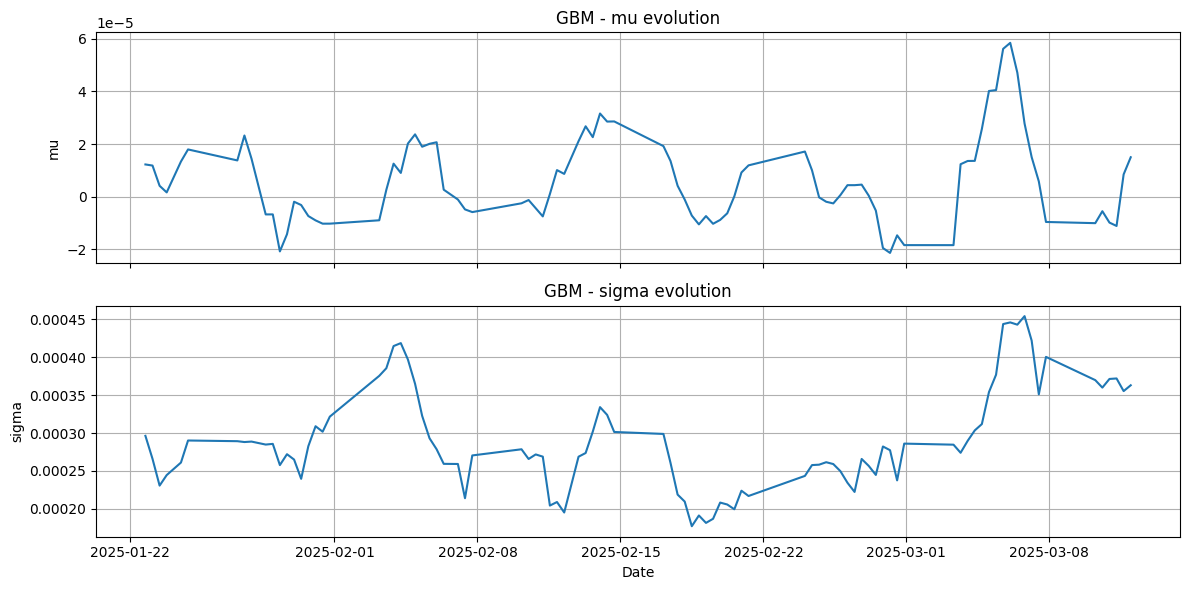

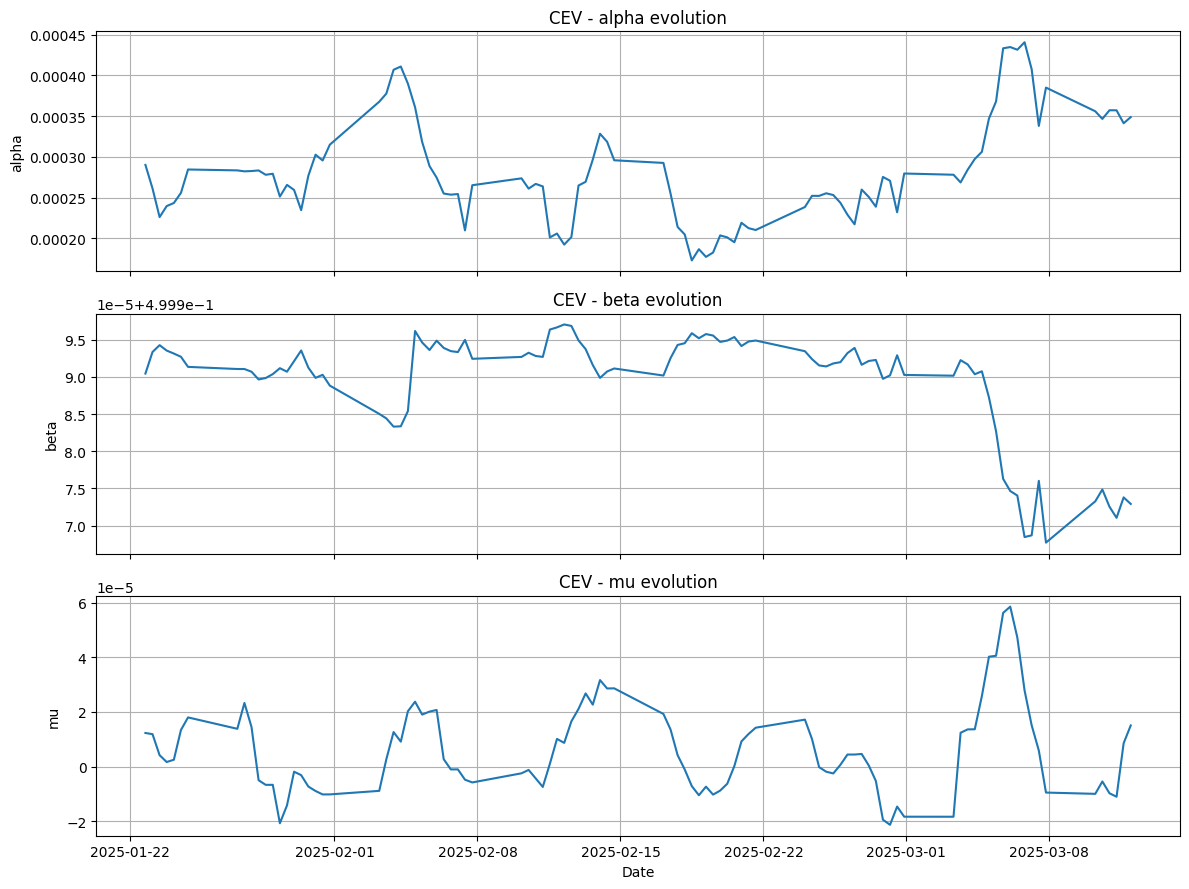

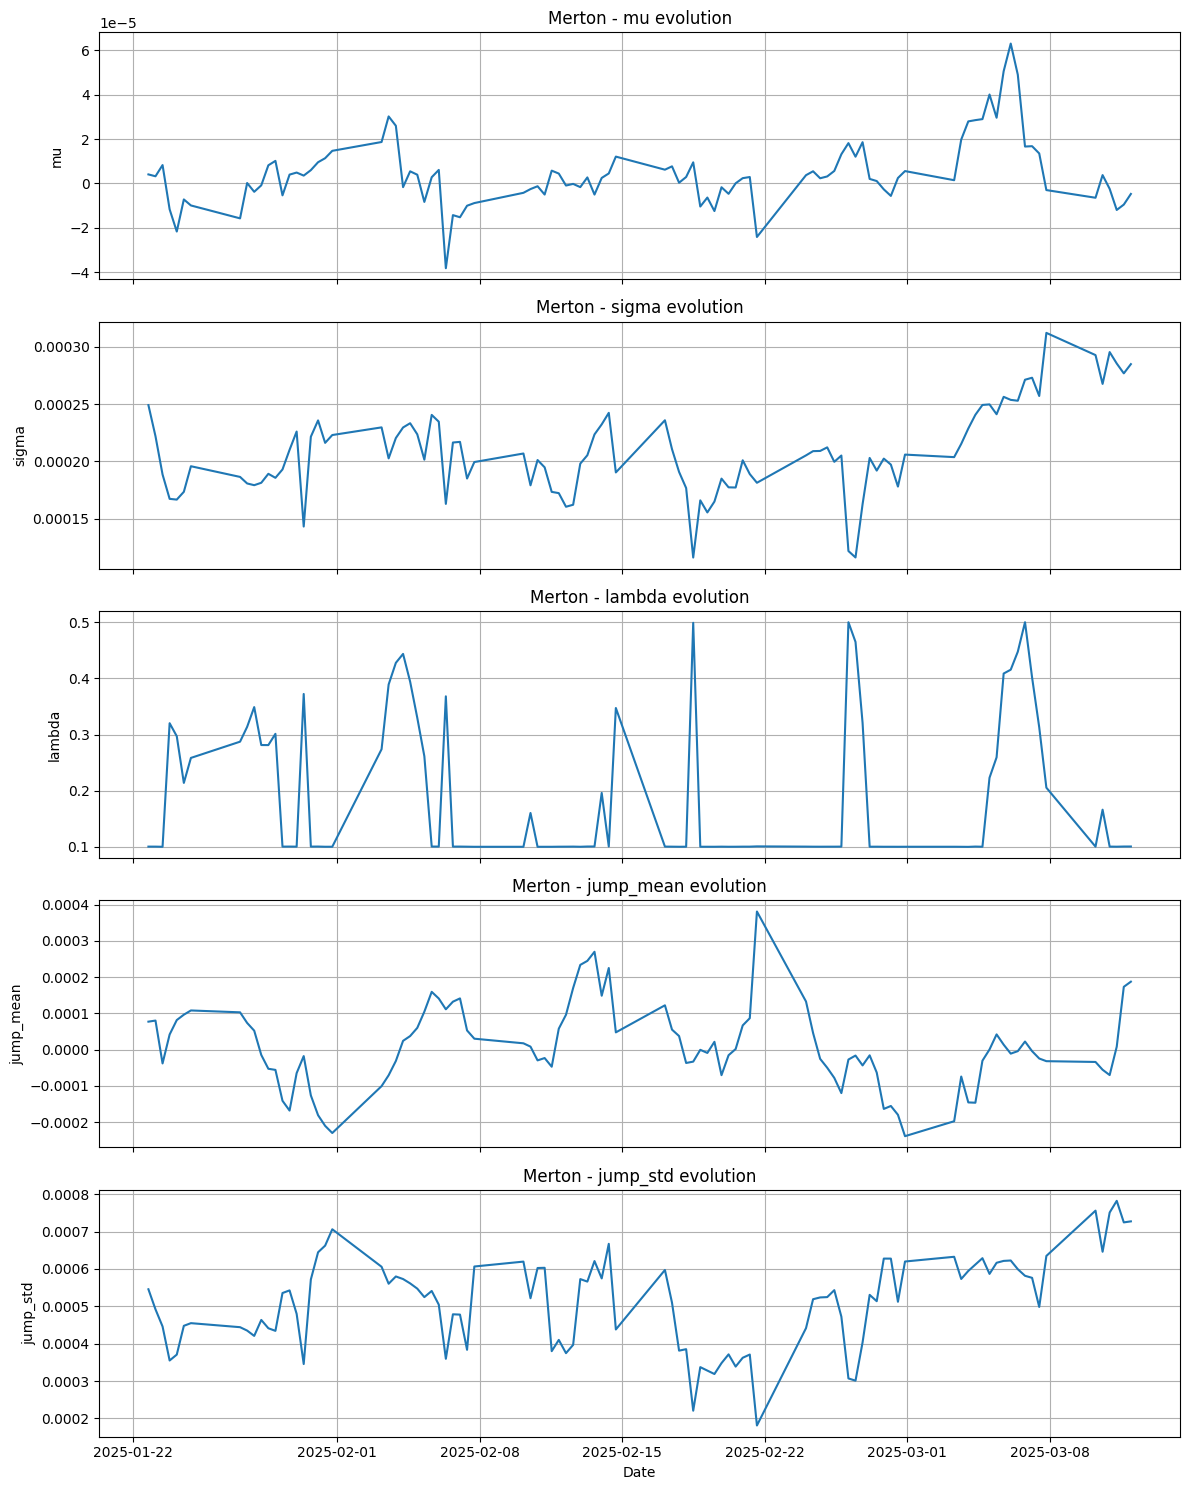

In [ ]:
# ============================
# ANALYSIS AND VISUALIZATION
# ============================

def calculate_model_metrics(params_df, model_name, actual_data):
    """
    Calculate model performance metrics.

    Parameters:
    -----------
    params_df : pd.DataFrame
        DataFrame with calibrated parameters
    model_name : str
        Model name ('GBM', 'CEV', or 'Merton')
    actual_data : pd.DataFrame
        DataFrame with actual prices and returns

    Returns:
    --------
    dict
        Dictionary with performance metrics
    """
    # Skip if no parameters
    if params_df.empty:
        return {}

    # Calculate average parameters
    avg_params = params_df.mean()

    # Calculate AIC and BIC
    n_params = {
        'GBM': 2,
        'CEV': 3,
        'Merton': 5
    }.get(model_name, 0)

    n_obs = len(actual_data)

    # Calculate metrics if we have log-likelihood
    if 'log_likelihood' in params_df.columns:
        avg_ll = avg_params['log_likelihood']
        aic = 2 * n_params - 2 * avg_ll
        bic = n_params * np.log(n_obs) - 2 * avg_ll
    else:
        aic = np.nan
        bic = np.nan

    # Return metrics
    return {
        'model': model_name,
        'parameters': avg_params.to_dict(),
        'n_windows': len(params_df),
        'AIC': aic,
        'BIC': bic
    }

def plot_parameter_evolution(params_df, model_name):
    """
    Plot the evolution of model parameters over time.

    Parameters:
    -----------
    params_df : pd.DataFrame
        DataFrame with calibrated parameters
    model_name : str
        Model name ('GBM', 'CEV', or 'Merton')
    """
    if params_df.empty:
        print(f"No parameters available for {model_name}")
        return

    # Define parameters to plot based on model
    if model_name == 'GBM':
        plot_cols = ['mu', 'sigma']
    elif model_name == 'CEV':
        plot_cols = ['alpha', 'beta', 'mu']
    elif model_name == 'Merton':
        plot_cols = ['mu', 'sigma', 'lambda', 'jump_mean', 'jump_std']
    else:
        return

    # Filter columns that exist in the DataFrame
    plot_cols = [col for col in plot_cols if col in params_df.columns]

    if not plot_cols:
        return

    # Create figure with subplots
    n_plots = len(plot_cols)
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 3*n_plots), sharex=True)

    # Handle case with only one parameter
    if n_plots == 1:
        axes = [axes]

    # Plot each parameter
    for i, col in enumerate(plot_cols):
        axes[i].plot(params_df.index, params_df[col])
        axes[i].set_title(f"{model_name} - {col} evolution")
        axes[i].set_ylabel(col)
        axes[i].grid(True)

    # Set common x-label
    if isinstance(params_df.index, pd.DatetimeIndex):
        plt.xlabel('Date')
    else:
        plt.xlabel('Window Index')

    plt.tight_layout()
    plt.show()

metrics_gbm = calculate_model_metrics(df_results_gbm, 'GBM', processed_data)
metrics_cev = calculate_model_metrics(df_results_cev, 'CEV', processed_data)
metrics_merton = calculate_model_metrics(df_results_merton, 'Merton', processed_data)

print(f"Metrics for GBM: {metrics_gbm}")
print(f"Metrics for CEV: {metrics_cev}")
print(f"Metrics for Merton: {metrics_merton}")

plot_parameter_evolution(df_results_gbm, 'GBM')
plot_parameter_evolution(df_results_cev, 'CEV')
plot_parameter_evolution(df_results_merton, 'Merton')


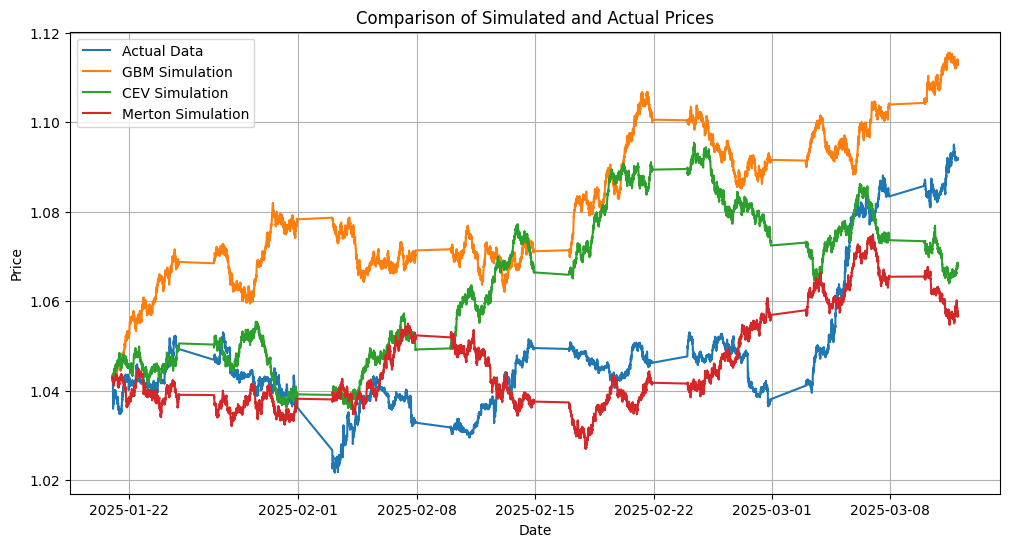

GBM MSE: 0.0012326964597030362
CEV MSE: 0.0005542124092513201
Merton MSE: 0.00014259337411057148


In [ ]:
# ============================
# FINAL COMPARISON AND METRICS
# ============================

# Define simulation parameters
S0 = fx_data_5m['Close'].iloc[0]  # Initial price
steps = len(processed_data)  # Number of steps to simulate (match actual data)

# Simulate paths for each model
# Adjust the number of simulation steps to match the actual data length
simulated_gbm = simulate_gbm(S0, metrics_gbm['parameters']['mu'], metrics_gbm['parameters']['sigma'], steps-1, dt=1, antithetic=True, n_paths=1) # Changed steps to steps-1
simulated_cev = simulate_cev(S0, metrics_cev['parameters']['alpha'], metrics_cev['parameters']['beta'], metrics_cev['parameters']['mu'], steps-1, dt=1, antithetic=True, n_paths=1) # Changed steps to steps-1
simulated_merton = simulate_merton(S0, metrics_merton['parameters']['mu'], metrics_merton['parameters']['sigma'], metrics_merton['parameters']['lambda'], metrics_merton['parameters']['jump_mean'], metrics_merton['parameters']['jump_std'], steps-1, dt=1, antithetic=True, n_paths=1) # Changed steps to steps-1


# --- Plot simulations against actual data ---
plt.figure(figsize=(12, 6))
plt.plot(processed_data.index, processed_data['Close'], label='Actual Data')
plt.plot(processed_data.index, simulated_gbm, label='GBM Simulation')
plt.plot(processed_data.index, simulated_cev, label='CEV Simulation')
plt.plot(processed_data.index, simulated_merton, label='Merton Simulation')
plt.title('Comparison of Simulated and Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Calculate and print MSE ---
from sklearn.metrics import mean_squared_error #Import mean_squared_error
mse_gbm = mean_squared_error(processed_data['Close'], simulated_gbm)
mse_cev = mean_squared_error(processed_data['Close'], simulated_cev)
mse_merton = mean_squared_error(processed_data['Close'], simulated_merton)

print(f"GBM MSE: {mse_gbm}")
print(f"CEV MSE: {mse_cev}")
print(f"Merton MSE: {mse_merton}")